In [1]:
import numpy as np
import pandas as pd
import math
import copy
import random
import plconnect.functions as plf
import scipy
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import johnsonsu, genlogistic,norm,pearson3
from scipy import interpolate
from matplotlib import pyplot as plt
%matplotlib inline
from random import seed
from IPython.display import clear_output
import pickle
from collections import OrderedDict
import os


In [2]:

uwi_list = []
dataset = None
#Define the independent variables and the dependent variable. The last variable is the target
curves_to_fetch =  ["RHOB","ILD", "GR", "PHIT_D","Facies2","GRCLN","GRSH"]   #"RHOMAND"

#Define the set above with depth included, cleaning up any &/$ 

curves_to_fetch_prediction = copy.deepcopy(curves_to_fetch)
#print(curves_to_fetch_prediction)



column_names = ["DEPTH"]
for curve_name in curves_to_fetch:
    column_names.append(curve_name)

#print(column_names)


training_zones = ["Green"] #Add more zones that do not overlap to filter to higher quality training data 
    

grid = "Same As:{}".format(curves_to_fetch[-1])  #Can also be default. It's set to Same as Target curve 

 
SelectTrainingWellsFromAGroup = False  
TrainingWellsGroupName = "AllProjWells"  #If SelectTrainingWellsFromAGroup=True then this well group will be used


def get_uwis_in_well_group(group):
    from plconnect.filters import DataFilter, DataFilterClassNames, DataFilterCondition, DataFilterFunctions, DataFilterOperator, DataFilterClauses
    f = DataFilter()
    conditions = []
    f.add_resultset(Function = DataFilterFunctions.Select, What = DataFilterClassNames.Wells, From="Group:{}".format(group), Conditions = conditions)
    result = f.run(columns=["UWI"])
    if result.shape[0] > 0:
        return result.UWI.tolist()


    
uwi_list = []
if SelectTrainingWellsFromAGroup:
    uwi_list = get_uwis_in_well_group(TrainingWellsGroupName)
    if len(uwi_list) == 0:
        sys.stderr.write("Error: No wells  in the specified Well Group {}".format(TrainingWellsGroupName) )
    
else:
    uwi_list = plf.get_current_selected_wells()


frames = []

#########Fetch Training data#########################
#If you are using multiple zones ensure the zones don't overlap

print(uwi_list)


for uwi in uwi_list:
    for zone in training_zones:

        df = plf.get_curveexpressions_for_uwi(uwi, curves_to_fetch, training_zones[0], grid = grid)
        df.columns = column_names #Fix columns names (remove &)
        df.dropna(inplace = True)
       
        frames.append(df) #add it to the list of training sets

    
    
    
for curve_name in curves_to_fetch:
    column_names.append(curve_name)


dataset = pd.concat(frames)
print(dataset)
#dataset.drop(["DEPTH"], axis=1, inplace = True)
rhob = list(dataset['RHOB'])   #Here, len(rhob) =19003
phit_d = list(dataset['PHIT_D'])   #Here, len(rhob) =19003
depth = list(dataset['DEPTH'])   #Here, len(rhob) =19003


['608174035200']
      DEPTH    RHOB     ILD       GR    PHIT_D  Facies2  GRCLN   GRSH
0    6102.0  2.2290   0.594   97.737  0.086231      0.0   50.0  100.0
1    6102.5  2.2340   0.607   98.392  0.082226      0.0   50.0  100.0
2    6103.0  2.2330   0.620   99.422  0.079851      0.0   50.0  100.0
3    6103.5  2.2290   0.629   99.197  0.082836      0.0   50.0  100.0
4    6104.0  2.2270   0.639   99.265  0.085001      0.0   50.0  100.0
5    6104.5  2.2310   0.654  100.590  0.098229      0.0   50.0  100.0
6    6105.0  2.2400   0.680  101.248  0.115463      0.0   50.0  100.0
7    6105.5  2.2520   0.726   99.841  0.124972      0.0   50.0  100.0
8    6106.0  2.2650   0.806   95.953  0.118202      0.0   50.0  100.0
9    6106.5  2.2780   0.937   90.022  0.100776      0.0   50.0  100.0
10   6107.0  2.2830   1.116   85.353  0.090042      0.0   50.0  100.0
11   6107.5  2.2750   1.350   84.747  0.095238      0.0   50.0  100.0
12   6108.0  2.2610   1.713   86.899  0.113573      0.0   50.0  100.0
13 

In [3]:
#Set Num_samples
Num_samples = len(dataset['DEPTH'])

#Setting no. of iterations

def createList(r1, r2):
    return (list(np.arange(r1, r2+1, 1)))


#ITER = createList(50, 100)
ITER = [5,10,15,20,30,40,50,60,70,80,90,100]   
print(len(ITER))

12


Here is the Histogram GR data:


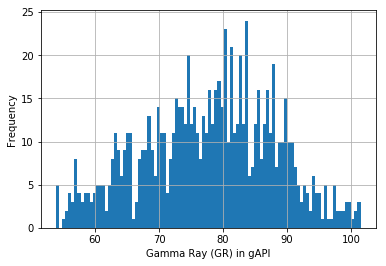


For this GR data:
max = 101.464 
min = 53.94 
mode = 88.935 
range = 47.524 
mean = 77.77532936979782 
variance 105.84044817829098
-----------------------------


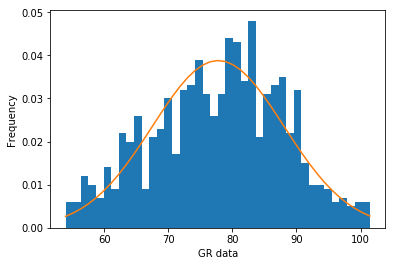

In [4]:
#GR distribution
gr = list(dataset['GR'])
print("Here is the Histogram GR data:")
hist = dataset['GR'].hist(bins=100)
plt.xlabel("Gamma Ray (GR) in gAPI")
plt.ylabel("Frequency")
plt.show()

# Max anad Min for the GR
GR_max_value = dataset['GR'].max() 
GR_min_value = dataset['GR'].min()

#distname=str(input('Judging by the skewness of data, the distribution is:'))

#Finding max, min, mode, range, and mean for the distribution 
df_GR_modes = dataset['GR'].mode()
df_GR_mode = df_GR_modes.max()
GR_mode = df_GR_mode 
GR_range = GR_max_value - GR_min_value
GR_mean = dataset['GR'].mean()
GR_variance = dataset['GR'].var()
print('\nFor this GR data:\nmax =',GR_max_value,'\nmin =',GR_min_value,'\nmode =',GR_mode,'\nrange =',GR_range,'\nmean =',GR_mean,'\nvariance',GR_variance)   
print('-----------------------------')

# Test for curve fitting

_, bins, _ = plt.hist(gr, 40, density=1)
A, B = scipy.stats.norm.fit(gr)
best_fit_line = scipy.stats.norm.pdf(bins, A,B )
plt.plot(bins, best_fit_line)
plt.xlabel("GR data")
plt.ylabel("Frequency")
plt.show()

In [5]:
#For GR data, GRCLN and GRSH

#grsh = list(dataset['GRSH'])       #print(grcln)
grcln = list(dataset['GRCLN'])      #print(grcln)

RHOBclay, RHOBqtz = 2.6, 2.65

def VshIGR(Gr,Grcl,Grsh):
    V = (Gr-Grcl)/(Grsh-Grcl)
    if V>=1:
        return(float(1))
    else:
        return(V)


def cmp(gr,grcln,A,B):
    f = 1
    L=[]
    for i in range(len(gr)):
        VC = VshIGR(gr[i],grcln[i],A)
        X = ((RHOBclay) * (VC - (VC*0.1)))  + ( RHOBqtz * (1-VC))
        if X<B[i]:
            f=0
            break
    return(f)

def sh_cal(gr,grcln,M1,M2,RB):
    i,t = 0,0
    while(i<1):
        sh  = random.uniform(M1,M2)
        X = cmp(gr,grcln,sh,RB)
        if X>i:
            return(sh)
            i+=1
        
def Vsh_Calc(gr,grcln,Minsh,Maxsh,RB):           
    L = []
    for i in range(len(gr)):
        SH = sh_cal(gr,grcln,Minsh,Maxsh,RB)
        VC  = VshIGR(gr[i],grcln[i],SH)
        L.append(VC)
    return(L)


def Iter_Vsh(gr,grcln,Minsh,Maxsh,RB,it):
    Lit = []
    for i in range(it): 
        Lit.extend(Vsh_Calc(gr,grcln,Minsh,Maxsh,RB)) 
    return(Lit)


def n_iterVshCalc(gr,grcln,Minsh,Maxsh,RB):
    F=[]
    for i in range(len(ITER)):
        F.append(Iter_Vsh(gr,grcln,Minsh,Maxsh,RB,ITER[i])  )  
    return(F)


#Obtain Vsh i.e. (Vcl) curves

Vclay = n_iterVshCalc(gr,grcln,80,120,rhob) 


In [6]:
min(Vclay[-1])

0.0563703313707752

In [7]:
#For Facieswise Vcl :

facies = list(dataset['Facies2'])

def split_data(G,it):
    L = copy.deepcopy(G)
    X=[]
    splits = np.array_split(L, it)
    for i in range(it):
        X.append(list(splits[i]))
    return(X) 


def Facies_Data(G):
    i,X,L,Y = 0,[],[],[]
    for i in range(Num_samples):
        if facies[i] == 0:
            X.append(G[i])  
        if facies[i] == 1:
            L.append(G[i])     
        if facies[i] == 2:
            Y.append(G[i])
    return(X,L,Y)


def Facieswise_split(G):
    L = copy.deepcopy(G)
    sh,sdbr,sdhc =  Facies_Data(L)
    return(sh,sdbr,sdhc)


def Facsplit_iter(G,j):
    L = split_data(G,j)
    A1,A2,A3 = [],[],[] 
    for i in range(len(L)):
        a, b, c = Facieswise_split(L[i])
        A1.extend(a)
        A2.extend(b)
        A3.extend(c)
    return(A1,A2,A3)

def Vcl_finaljoin(G):
    SH,SDBR,SDHC = [],[],[] 
    for i in range(len(ITER)):
        a ,b, c = Facsplit_iter(G[i],ITER[i])
        SH.append(a)
        SDBR.append(b)
        SDHC.append(c)
    return(SH,SDBR,SDHC) 

f1Vc,f2Vc,f3Vc = Vcl_finaljoin(Vclay)

len(f1Vc[0])

2060

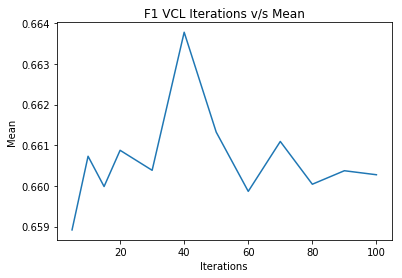

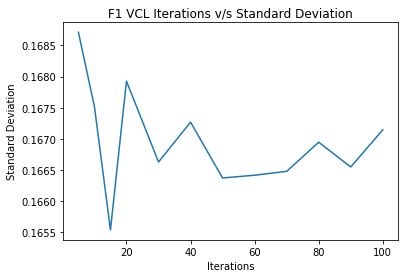

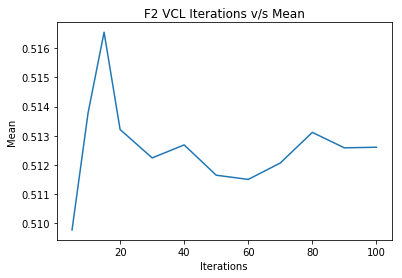

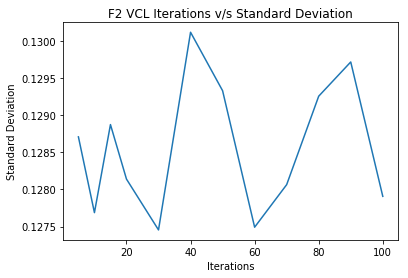

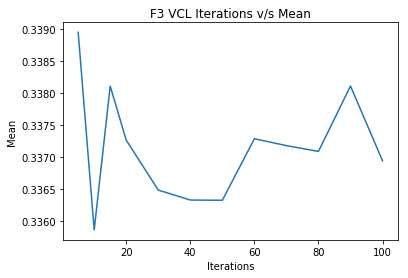

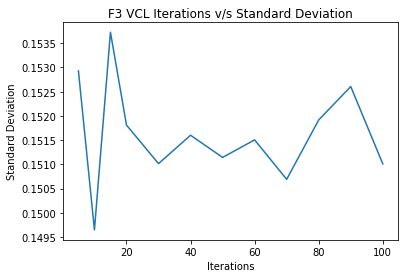

In [9]:
#Means and STDevs of Vcl Data calculation

def Mean_stdev(A):
    Me,St = [],[]
    for i in range(len(A)):
        meen = np.mean(A[i])
        stdevin = np.std(A[i])
        Me.append(meen)
        St.append(stdevin)
    return(Me,St)

F1mean,F1STDV = Mean_stdev(f1Vc)     #print(F1STDV)
F2mean,F2STDV = Mean_stdev(f2Vc)
F3mean,F3STDV = Mean_stdev(f3Vc)


# plotting the Mean and Std dev


plt.plot(ITER, F1mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F1 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F1STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F1 VCL Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F2mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F2 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F2STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F2 VCL Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F3mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F3 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F3STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F3 VCL Iterations v/s Standard Deviation')
plt.show()

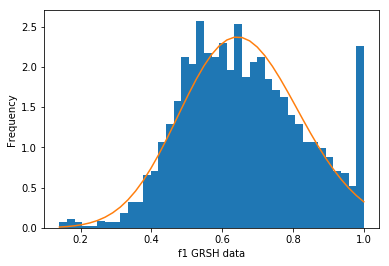

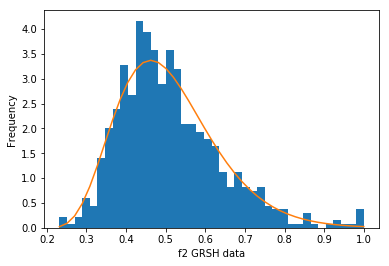

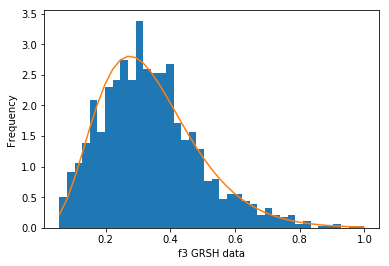

In [10]:
#Fit of Pearson Distribution over facieswise Vcl data:

_, bins, _ = plt.hist(f1Vc[0], 40, density=1)
f1A,f1B,f1C = scipy.stats.pearson3.fit(f1Vc[0])
best_fit_line = scipy.stats.pearson3.pdf(bins, f1A,f1B,f1C)
plt.plot(bins, best_fit_line)
plt.xlabel("f1 GRSH data")
plt.ylabel("Frequency")
plt.show()

_, bins, _ = plt.hist(f2Vc[0], 40, density=1)
f2A,f2B,f2C = scipy.stats.pearson3.fit(f2Vc[0])
best_fit_line = scipy.stats.pearson3.pdf(bins, f2A,f2B,f2C)
plt.plot(bins, best_fit_line)
plt.xlabel("f2 GRSH data")
plt.ylabel("Frequency")
plt.show()

_, bins, _ = plt.hist(f3Vc[0], 40, density=1)
f3A,f3B,f3C = scipy.stats.pearson3.fit(f3Vc[0])
best_fit_line = scipy.stats.pearson3.pdf(bins, f3A,f3B,f3C)
plt.plot(bins, best_fit_line)
plt.xlabel("f3 GRSH data")
plt.ylabel("Frequency")
plt.show()


In [11]:
# P10, P50, P90 of the distribution of Vcl:

def itp10p50p90(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]    
    p10 = np.percentile(L, 90)
    p50 = np.percentile(L, 50)
    p90 = np.percentile(L, 10)
    i=0
    while (i<len(L)):     
        if L[i] <= p10:      
            P90.append(L[i])
        else: 
            P90.append(np.NaN)
            
        if L[i] <= p50:      
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
            
        if L[i] <= p90:      
            P10.append(L[i])
        else:
            P10.append(np.NaN)
        i+=1    
        
    return(P10,P50,P90)


def p10_p50_p90values(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[] 
    for i in range(len(L)):
        a, b, c = itp10p50p90(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)

def Iter_P105090(G):
    f10,f50,f90 = [],[],[] 
    for i in range(len(ITER)):
        a ,b, c = p10_p50_p90values(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90) 


# Based on Confidence interval of the most likely value:


def Vclitp10p50p90ConfInt(G,ig):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.pearson3.fit(L)                 #print(params)
    def your_density(x):
        return -stats.pearson3.pdf(x,*params)
    ASD = minimize(your_density,ig).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    

def Vclp10p50p90listConfInt(G,i,ig):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = Vclitp10p50p90ConfInt(L[i],ig)
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def VclIter_P105090ConfInt(G,ig):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = Vclp10p50p90listConfInt(G[i],ITER[i],ig)
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)  



f1Vcp10, f1Vcp50, f1Vcp90 = Iter_P105090(f1Vc)  #print(GLDp50), , 
f2Vcp10, f2Vcp50, f2Vcp90 = Iter_P105090(f2Vc)
f3Vcp10, f3Vcp50, f3Vcp90 = Iter_P105090(f3Vc)


f1Vcp10C, f1Vcp50C, f1Vcp90C = VclIter_P105090ConfInt(f1Vc,0.6)  #print(GLDp50), , 
f2Vcp10C, f2Vcp50C, f2Vcp90C = VclIter_P105090ConfInt(f2Vc,0.5)
f3Vcp10C, f3Vcp50C, f3Vcp90C = VclIter_P105090ConfInt(f3Vc,0.5)

Here is the Histogram RHOB data:


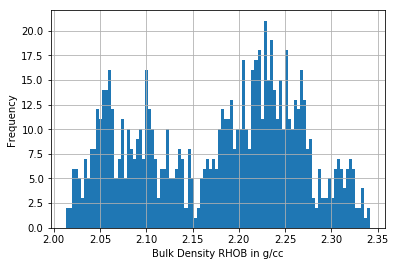


For this RHOB data:
max = 2.3419 
min = 2.013 
mode = 2.193 
range = 0.3289 
mean = 2.1765495838287716 
variance 0.0072853697170884935
-----------------------------


In [12]:
# Generating  Histogram for Bulk Density Data

Num_samples = len(dataset['DEPTH'])

RHOF= 1   #rho fluid
print("Here is the Histogram RHOB data:")
hist = dataset['RHOB'].hist(bins=100)
plt.xlabel("Bulk Density RHOB in g/cc")
plt.ylabel("Frequency")
plt.show()

# Max anad Min for the RHOB
RHOB_max_value = dataset['RHOB'].max() 
RHOB_min_value = dataset['RHOB'].min()


#Finding max, min, mode, range, and mean for the distribution 
df_RHOB_modes = dataset['RHOB'].mode()
df_RHOB_mode = df_RHOB_modes.max()
RHOB_mode = df_RHOB_mode 
RHOB_range = RHOB_max_value - RHOB_min_value
RHOB_mean = dataset['RHOB'].mean()
RHOB_variance = dataset['RHOB'].var()
print('\nFor this RHOB data:\nmax =',RHOB_max_value,'\nmin =',RHOB_min_value,'\nmode =',RHOB_mode,'\nrange =',RHOB_range,'\nmean =',RHOB_mean,'\nvariance',RHOB_variance)   
print('-----------------------------')


In [13]:
# Rhob Data By Facies

rhobshale , rhobsandbrine, rhobsandHC = Facies_Data(rhob)
lenrsh, lenrsdbr, lenrsdhc  = len(rhobshale), len(rhobsandbrine), len(rhobsandHC)

# Useful Functions:

def varystuff(stuff ,length, Min,Max,S):           
    L = []
    random.seed(S)
    for i in range(length):
        p,pp = 0,0
        while pp<1:
            p = random.uniform(Min, Max)
            if p>stuff[i]:
                L.append(p)
                pp+=1
    return(L)

def normvarystuff(stuff ,length, mean,stddev):           
    L = []
    random.seed(10)
    for i in range(length):
        p,pp = 0,0
        while pp<1:
            p = np.random.normal(mean, stddev)
            if p>stuff[i]:
                L.append(p)
                pp+=1
    return(L)

def Remv_nan(A):
    L = []
    for i in range(len(ITER)):
        L.append([x for x in A[i] if pd.isnull(x) == False])
    return(L)

In [14]:
#RHOMA Calculation:

RHOBclay, RHOBqtz = 2.6, 2.65

def Iter_RHOMA(D):
    Lit =[]
    for i in range(len(D)):
        Lit.append(( (RHOBclay) * (D[i] - (D[i]*0.1)) ) + ( RHOBqtz * (1-D[i])))  #Rhomatrix= ((RHOBCLAY*VCLAY+RHOBQUARTZ*(1-VCLAY))
    return(Lit)
 #np.random.normal(2.5, 0.07,200)   #np.random.uniform(2.3,2.7,200)

lenf1RHOMA , lenf2RHOMA , lenf3RHOMA, tot_samples,f1RHOMA,f2RHOMA,f3RHOMA = [],[],[],[],[],[],[]
for i in range(len(ITER)):
        f1RHOMA.append(Iter_RHOMA(f1Vc[i])) #print(GLDRHOMA )
        f2RHOMA.append(Iter_RHOMA(f2Vc[i]))
        f3RHOMA.append(Iter_RHOMA(f3Vc[i]))

for i in range(len(ITER)):
    lenf1RHOMA.append(len(f1RHOMA[i]))
    lenf2RHOMA.append(len(f2RHOMA[i]))
    lenf3RHOMA.append(len(f3RHOMA[i]))
    tot_samples.append(len(f1RHOMA[i])+len(f2RHOMA[i])+len(f3RHOMA[i]))

In [15]:
# Lets define the function of Density Porosity over which we are running Monte Carlo Simulation

def Eqn_Density_Porosity(rhoma,x):
    return ((rhoma-x)/(rhoma-RHOF))



#Porosity Distribution
def MC_density_porosity_nSamples(num_samples,RHOMA,rb):
    L =[]
    r = len(rb)
    for i in range(num_samples):
        L.append(Eqn_Density_Porosity(RHOMA[i],rb[i%r]))   #rhob[i]
    return(L)

f1DP,f2DP,f3DP = [],[],[]

#Computing Density_Porosity for facies

for i in range(len(ITER)):
    f1DP.append(MC_density_porosity_nSamples(lenf1RHOMA[i],f1RHOMA[i],rhobshale))
    f2DP.append(MC_density_porosity_nSamples(lenf2RHOMA[i],f2RHOMA[i],rhobsandbrine))
    f3DP.append(MC_density_porosity_nSamples(lenf3RHOMA[i],f3RHOMA[i],rhobsandHC))

len(f1DP[0])

2060

In [28]:
# P10, P50, P90 of the Porosity distribution as well as estimates Based on Confidence interval of the most likely value:

def Poritp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.genlogistic.fit(L)                 #print(params)
    def your_density(x):
        return -stats.genlogistic.pdf(x,*params)
    ASD = minimize(your_density,0.5).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    

def Porp10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = Poritp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def PorIter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = Porp10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    
    



f1Dp10C, f1Dp50C, f1Dp90C = PorIter_P105090ConfInt(f1DP)  #print(GLDp50), , 
f2Dp10C, f2Dp50C, f2Dp90C = PorIter_P105090ConfInt(f2DP)
f3Dp10C, f3Dp50C, f3Dp90C = PorIter_P105090ConfInt(f3DP)



f1Dp10, f1Dp50, f1Dp90 = Iter_P105090(f1DP)  #print(GLDp50), , 
f2Dp10, f2Dp50, f2Dp90 = Iter_P105090(f2DP)
f3Dp10, f3Dp50, f3Dp90 = Iter_P105090(f3DP)


In [29]:
len(f2Dp10[-1])

14000

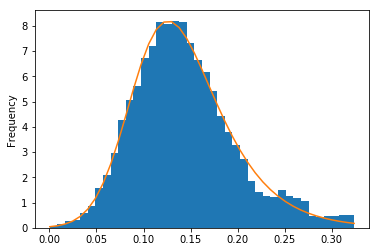

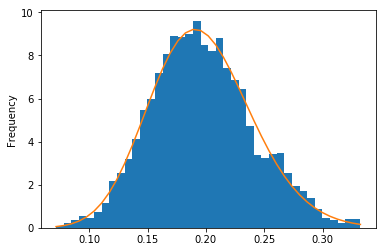

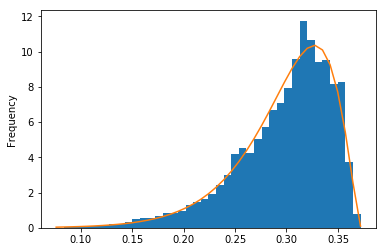

In [30]:

_, bins, _ = plt.hist(f1DP[-1], 40, density=1)
f1R,f1S,f1T = scipy.stats.genlogistic.fit(f1DP[-1])
best_fit_line = scipy.stats.genlogistic.pdf(bins, f1R,f1S,f1T)
plt.plot(bins, best_fit_line)
plt.ylabel("Frequency")
plt.show()

_, bins, _ = plt.hist(f2DP[-1], 40, density=1)
f2R,f2S,f2T,f2a = scipy.stats.johnsonsu.fit(f2DP[-1])
best_fit_line = scipy.stats.johnsonsu.pdf(bins, f2R,f2S,f2T,f2a)
plt.plot(bins, best_fit_line)
plt.ylabel("Frequency")
plt.show()

_, bins, _ = plt.hist(f3DP[-1], 40, density=1)
f3R,f3S,f3T = scipy.stats.pearson3.fit(f3DP[-1])
best_fit_line = scipy.stats.pearson3.pdf(bins, f3R,f3S,f3T)
plt.plot(bins, best_fit_line)
plt.ylabel("Frequency")
plt.show()



In [31]:
def porbunch(F1,F2,F3,it):
    i,f1,f2,f3, L = 0,0,0,0,[]

    while i<(tot_samples[it]):
        if i<tot_samples[it] and facies[i%Num_samples] == 0:
            L.append(F1[f1])
            f1+=1
        elif i<tot_samples[it] and facies[i%Num_samples] == 1:
            L.append(F2[f2])
            f2+=1       
        elif i<tot_samples[it] and facies[i%Num_samples] == 2:
            L.append(F3[f3])
            f3+=1   
        i+=1
    return(L)
FDP,VC = [],[]
for i in range(len(ITER)):
    FDP.append(porbunch(f1DP[i],f2DP[i],f3DP[i],i))    #print(FDP) len(FDP)
    VC.append( porbunch(f1Vc[i],f2Vc[i],f3Vc[i],i))    


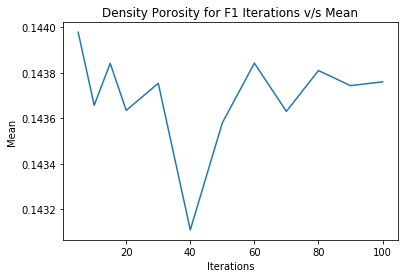

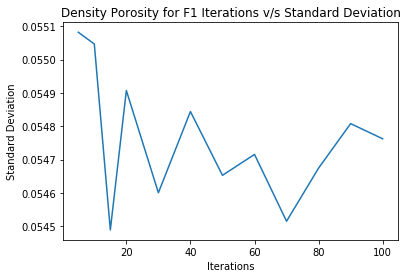

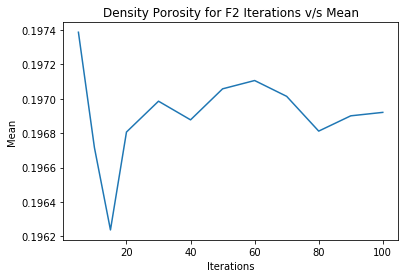

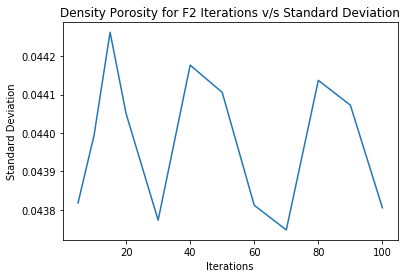

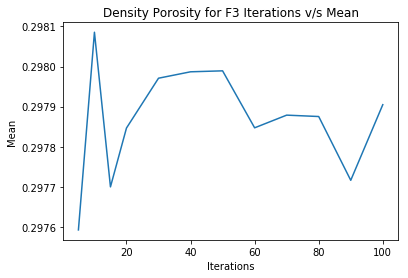

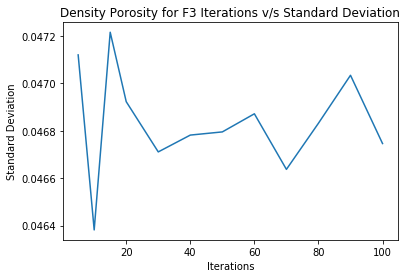

In [32]:
#Means and STDevs of Porosity Data calculation

F1mean,F1STDV = Mean_stdev(f1DP)     #print(F1STDV)
F2mean,F2STDV = Mean_stdev(f2DP)
F3mean,F3STDV = Mean_stdev(f3DP)


# plotting the Mean and Std dev

plt.plot(ITER, F1mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F1 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F1STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F1 Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F2mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F2 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F2STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F2 Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F3mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F3 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F3STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F3 Iterations v/s Standard Deviation')
plt.show()


In [33]:
#Preping data to send to PL


def packrhob(Fp,j,S):
    L,k = [],0
    for i in range(tot_samples[S]):
        if facies[i%(len(depth))] == j:
            L.append(Fp[k])  
            k+=1
        else:
            L.append(np.nan)
    return(L)


def iter_packrhob(AA,jj):
    FC = []
    for I in range(len(ITER)):
        FC.append(packrhob(AA[I],jj,I))
    return(FC)


def faciespordata(Fpor,j):  
    FD = []
    for p in range(len(Fpor)):
        FD.append(iter_packrhob(Fpor[p],j))    
    return(FD[0],FD[1],FD[2],FD[3])


f1VCL  = [f1Vc,f1Vcp10, f1Vcp50, f1Vcp90]
f2VCL  = [f2Vc,f2Vcp10, f2Vcp50, f2Vcp90]
f3VCL  = [f3Vc,f3Vcp10, f3Vcp50, f3Vcp90]

f1VCLC = [f1Vc,f1Vcp10C, f1Vcp50C, f1Vcp90C]
f2VCLC = [f2Vc,f2Vcp10C, f2Vcp50C, f2Vcp90C]
f3VCLC = [f3Vc,f3Vcp10C, f3Vcp50C, f3Vcp90C]

F1Vc, F1Vcp10, F1Vcp50, F1Vcp90    = faciespordata(f1VCL,0) 
F2Vc, F2Vcp10, F2Vcp50, F2Vcp90    = faciespordata(f2VCL,1) 
F3Vc, F3Vcp10, F3Vcp50, F3Vcp90    = faciespordata(f3VCL,2) 

F1Vc, F1Vcp10C, F1Vcp50C, F1Vcp90C = faciespordata(f1VCLC,0) 
F2Vc, F2Vcp10C, F2Vcp50C, F2Vcp90C = faciespordata(f2VCLC,1) 
F3Vc, F3Vcp10C, F3Vcp50C, F3Vcp90C = faciespordata(f3VCLC,2) 

f1por = [f1DP,f1Dp10, f1Dp50, f1Dp90]
f2por = [f2DP,f2Dp10, f2Dp50, f2Dp90]
f3por = [f3DP,f3Dp10, f3Dp50, f3Dp90]

f1porC = [f1DP,f1Dp10C, f1Dp50C, f1Dp90C]
f2porC = [f2DP,f2Dp10C, f2Dp50C, f2Dp90C]
f3porC = [f3DP,f3Dp10C, f3Dp50C, f3Dp90C]


F1DP, F1Dp10, F1Dp50, F1Dp90 = faciespordata(f1por,0)
F2DP, F2Dp10, F2Dp50, F2Dp90 = faciespordata(f2por,1)
F3DP, F3Dp10, F3Dp50, F3Dp90 = faciespordata(f3por,2)

F1DP, F1Dp10C, F1Dp50C, F1Dp90C = faciespordata(f1porC,0) 
F2DP, F2Dp10C, F2Dp50C, F2Dp90C = faciespordata(f2porC,1) 
F3DP, F3Dp10C, F3Dp50C, F3Dp90C = faciespordata(f3porC,2) 


In [36]:
len(F1Vc[-1])

84100

Here is the Histogram ILD data:


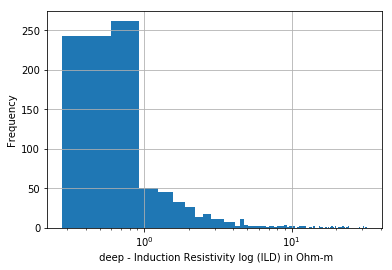


For this ILD data:
max = 32.251 
min = 0.279 
mode = 0.65 
range = 31.972 
mean = 2.5508406658739613 
variance 24.433031181725223
-----------------------------


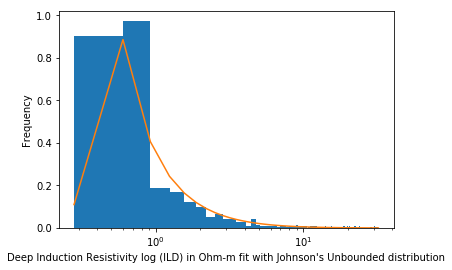

In [66]:
#ILD distribution
ild = list(dataset['ILD'])
print("Here is the Histogram ILD data:")
hist = dataset['ILD'].hist(bins=100)
plt.xlabel(" deep - Induction Resistivity log (ILD) in Ohm-m")
plt.ylabel("Frequency")
plt.xscale("log")
plt.show()

# Max anad Min for the GR
ILD_max_value = dataset['ILD'].max() 
ILD_min_value = dataset['ILD'].min()

#distname=str(input('Judging by the skewness of data, the distribution is:'))

#Finding max, min, mode, range, and mean for the distribution 
df_ILD_modes = dataset['ILD'].mode()
df_ILD_mode = df_ILD_modes.max()
ILD_mode = df_ILD_mode 
ILD_range = ILD_max_value - ILD_min_value
ILD_mean = dataset['ILD'].mean()
ILD_variance = dataset['ILD'].var()
print('\nFor this ILD data:\nmax =',ILD_max_value,'\nmin =',ILD_min_value,'\nmode =',ILD_mode,'\nrange =',ILD_range,'\nmean =',ILD_mean,'\nvariance',ILD_variance)   
print('-----------------------------')

# Test for curve fitting


#Fit for Johnson's Unbounded distribution
_, bins, _ = plt.hist(dataset['ILD'], 100, density=1)
ILDj1, ILDj2, ILDj3, ILDj4 = scipy.stats.johnsonsu.fit(dataset['ILD'])
best_fit_line = scipy.stats.johnsonsu.pdf(bins, ILDj1, ILDj2, ILDj3,ILDj4)
plt.plot(bins, best_fit_line)
plt.xlabel("Deep Induction Resistivity log (ILD) in Ohm-m fit with Johnson's Unbounded distribution")
plt.ylabel("Frequency")
plt.xscale("log")
plt.show()  

#For ILD data:

ildshale , ildsandbrine, ildsandHC = Facies_Data(ild)
lenrsh, lenrsdbr, lenrsdhc  = len(ildshale), len(ildsandbrine), len(ildsandHC)

min_ildshale,     max_ildshale     = min(ildshale),     max(ildshale)
min_ildsandbrine, max_ildsandbrine = min(ildsandbrine), max(ildsandbrine)
min_ildsandHC,    max_ildsandHC    = min(ildsandHC),    max(ildsandHC)



def ILDcalc(A,i):
    L = [] 
    for j in range(i):
        L.extend(A)   
    return(L) 

def Iter_ILDcalc(AA):
    Liter = []
    for i in range(len(ITER)):
        Liter.append(ILDcalc(AA,ITER[i])  )  
    return(Liter)

f1ild = Iter_ILDcalc(ildshale)
f2ild = Iter_ILDcalc(ildsandbrine)
f3ild = Iter_ILDcalc(ildsandHC)
Fild  = Iter_ILDcalc(ild)


In [67]:
#For saturation
a, m , n= 1, 1.8, 2  # From Pickett plot
RW = 0.033  #Using pickett plot

#Formation factor

def Formationf(phi):
    if phi== np.NaN:
        return(np.NaN)
    else: 
        F = a/(phi**(m))
        return (F)
    
def Iter_FF(A,S):
    AF= []
    for i in range(S):
        AF.append(Formationf(A[i]))
    return(AF)
        
def n_Iter_FF(aa,bb):
    AF = []
    for i in range(len(ITER)):
        AF.append((Iter_FF(aa[i],bb[i])))
    return(AF)

f1F  = n_Iter_FF(f1DP,lenf1RHOMA)
f2F  = n_Iter_FF(f2DP,lenf2RHOMA)
f3F  = n_Iter_FF(f3DP,lenf3RHOMA)
FDPF = n_Iter_FF(FDP,tot_samples)


In [73]:
#For Rw

RW = 0.033  #Using pickett plot

# Eqns for Sw:

def Eqn_Archie(F,rw, Rt):
    S = (  F*(rw) /(Rt) )**(1/n)
    if S>1:
        return(float(1))
    else:
        return(S)

def Eqn_Simandoux(F,RWA,Rt,Vsh,Rsh = 0.63):
    S = ( (F/2)*(RWA) * (  (  ( ((Vsh/Rsh)**2) - (4/(F*RWA*Rt)) )**(1/2)   )  - (Vsh/Rsh)   )  )

    return (S)

def Eqn_Indonesia( phie, RWA,Rt,Vsh,Rsh= 0.63):
    S = ( ( (1/Rt) ** (1/2) )    / ( (  ( (phie** (m))/ (a*RWA))**(1/2) )  + ( Vsh**(1- 0.5*Vsh) / (Rsh**(1/2))   ) ) ) ** (2/n)
    return(S)

In [79]:
#Archie's Saturation

def Iter_ArcSw(P,Q,R):
    L = []
    for i in range(len(P)):
        L.append(Eqn_Archie(P[i], Q, R[i] ))
    return(L)

def n_Iter_ArcSw(a,b,c):
    AA = []
    for i in range(len(ITER)):
        AA.append( Iter_ArcSw(a[i],b,c[i]) )        
    return(AA)

f1ArcSw = n_Iter_ArcSw(f1F, RW, f1ild)
f2ArcSw = n_Iter_ArcSw(f2F, RW, f2ild)
f3ArcSw = n_Iter_ArcSw(f3F, RW, f3ild)
FDPArcSw =n_Iter_ArcSw(FDPF,RW, Fild)


In [80]:
min(f1ArcSw[0])

0.20053145107612205

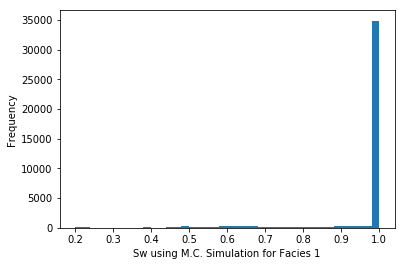

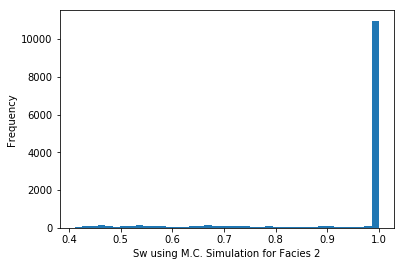

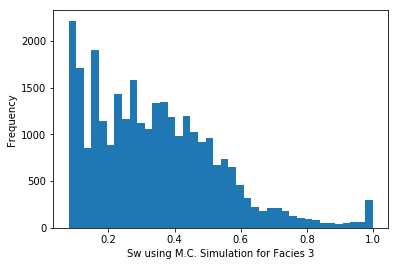

In [81]:
# Sw Data:

SWF1 = plt.hist(f1ArcSw[-1], 40)
plt.xlabel("Sw using M.C. Simulation for Facies 1")
plt.ylabel("Frequency")
plt.show()

SWF2 = plt.hist(f2ArcSw[-1], 40)
plt.xlabel("Sw using M.C. Simulation for Facies 2")
plt.ylabel("Frequency")
plt.show()

SWF3 = plt.hist(f3ArcSw[-1], 40)
plt.xlabel("Sw using M.C. Simulation for Facies 3")
plt.ylabel("Frequency")
plt.show()


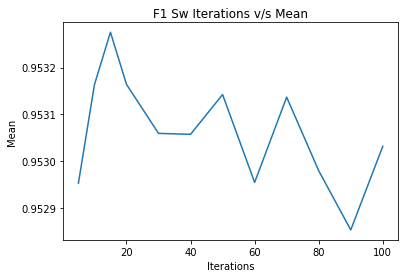

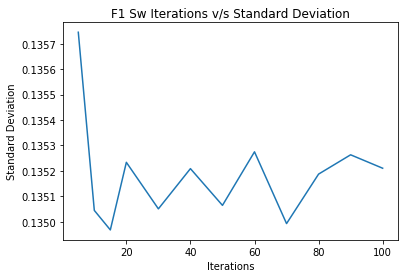

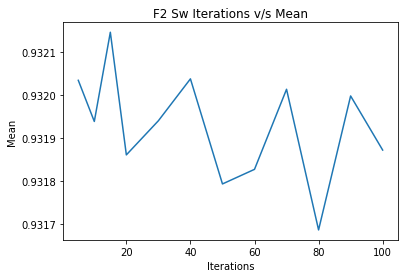

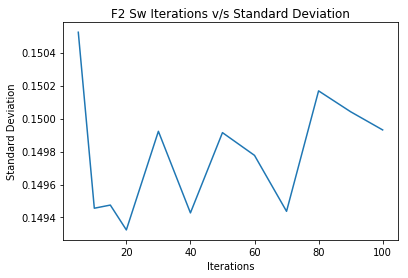

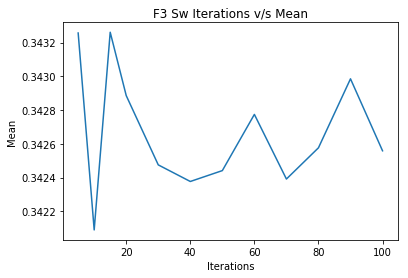

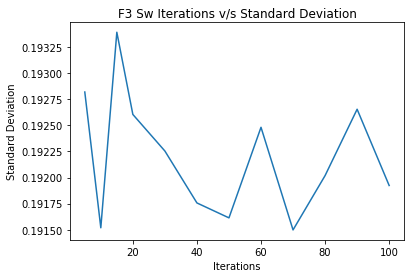

In [82]:
#Means and STDevs of Sw Data calculation

SwF1mean,SwF1STDV = Mean_stdev(f1ArcSw)     #print(F1STDV)
SwF2mean,SwF2STDV = Mean_stdev(f2ArcSw)
SwF3mean,SwF3STDV = Mean_stdev(f3ArcSw)

# plotting the Mean and Std dev


plt.plot(ITER, SwF1mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F1 Sw Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, SwF1STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F1 Sw Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, SwF2mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F2 Sw Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, SwF2STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F2 Sw Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, SwF3mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F3 Sw Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, SwF3STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F3 Sw Iterations v/s Standard Deviation')
plt.show()


In [83]:
#P10 P50 P90 for Sw:

def SATshbr_itp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    ASD = float(1)               #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    
def SATshbr_p10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = SATshbr_itp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def SATshbr_Iter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = SATshbr_p10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    


def SATitp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.pearson3.fit(L)                 #print(params)
    def your_density(x):
        return -stats.pearson3.pdf(x,*params)
    ASD = minimize(your_density,0.5).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    
def SATp10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = SATitp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def SATIter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = SATp10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    

f1ArcSwp10C, f1ArcSwp50C, f1ArcSwp90C = SATshbr_Iter_P105090ConfInt(f1ArcSw)
f2ArcSwp10C, f2ArcSwp50C, f2ArcSwp90C = SATshbr_Iter_P105090ConfInt(f2ArcSw)
f3ArcSwp10C, f3ArcSwp50C, f3ArcSwp90C = SATIter_P105090ConfInt(f3ArcSw)

f1ArcSwp10, f1ArcSwp50, f1ArcSwp90 = Iter_P105090(f1ArcSw)  #print(GLDp50)
f2ArcSwp10, f2ArcSwp50, f2ArcSwp90 = Iter_P105090(f2ArcSw)
f3ArcSwp10, f3ArcSwp50, f3ArcSwp90 = Iter_P105090(f3ArcSw) 

len(f1Dp10[0])==len(f1ArcSwp10[0])

True

In [84]:
#Preparing Sw data to send data to PL:

f1ARCSW  = [f1ArcSw,f1ArcSwp10, f1ArcSwp50, f1ArcSwp90]
f2ARCSW  = [f2ArcSw,f2ArcSwp10, f2ArcSwp50, f2ArcSwp90]
f3ARCSW  = [f3ArcSw,f3ArcSwp10, f3ArcSwp50, f3ArcSwp90]

f1ARCSWC = [f1ArcSw,f1ArcSwp10C, f1ArcSwp50C, f1ArcSwp90C]
f2ARCSWC = [f2ArcSw,f2ArcSwp10C, f2ArcSwp50C, f2ArcSwp90C]
f3ARCSWC = [f3ArcSw,f3ArcSwp10C, f3ArcSwp50C, f3ArcSwp90C]

F1ArcSw, F1ArcSwp10, F1ArcSwp50, F1ArcSwp90    = faciespordata(f1ARCSW,0) 
F2ArcSw, F2ArcSwp10, F2ArcSwp50, F2ArcSwp90    = faciespordata(f2ARCSW,1) 
F3ArcSw, F3ArcSwp10, F3ArcSwp50, F3ArcSwp90    = faciespordata(f3ARCSW,2) 

F1ArcSw, F1ArcSwp10C, F1ArcSwp50C, F1ArcSwp90C = faciespordata(f1ARCSWC,0) 
F2ArcSw, F2ArcSwp10C, F2ArcSwp50C, F2ArcSwp90C = faciespordata(f2ARCSWC,1) 
F3ArcSw, F3ArcSwp10C, F3ArcSwp50C, F3ArcSwp90C = faciespordata(f3ARCSWC,2) 


In [155]:
print(ITER)
ind = -1
itx = ITER[ind]

[5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [156]:
# Dummy depth

def createListDummy_depth(r1, r2):
    return (list(np.arange(r1, ((r2-2)/2)+1, 0.5)))

dl = len(F1DP[ind])
ddepth = createListDummy_depth(0,dl)

In [157]:
#Porosity Data:

f1Pordf= pd.DataFrame({'DEPTH': ddepth, 'f1DPGrsh' + str(itx): pd.Series(F1DP[ind]), 'f1DPGrsh' + str(itx)+'p10': pd.Series(F1Dp10[ind]),'f1DPGrsh' + str(itx)+'p50': pd.Series(F1Dp50[ind]),'f1DPGrsh' + str(itx)+'p90': pd.Series(F1Dp90[ind]) }) #print(PordfGLD)

f2Pordf = pd.DataFrame({'f2DPGrsh' + str(itx): pd.Series(F2DP[ind]), 'f2DPGrsh' + str(itx)+'p10': pd.Series(F2Dp10[ind]),'f2DPGrsh' + str(itx)+'p50': pd.Series(F2Dp50[ind]),'f2DPGrsh' + str(itx)+'p90': pd.Series(F2Dp90[ind]) })

f3Pordf= pd.DataFrame({ 'f3DPGrsh' + str(itx): pd.Series(F3DP[ind]), 'f3DPGrsh' + str(itx)+'p10': pd.Series(F3Dp10[ind]),'f3DPGrsh' + str(itx)+'p50': pd.Series(F3Dp50[ind]),'f3DPGrsh' + str(itx)+'p90': pd.Series(F3Dp90[ind]) })

POR = pd.DataFrame({  'AllFDPGrsh' + str(itx): pd.Series( FDP[ind])})
#print(POR)



#Sending Data to PL

#Adding this Porosity data to Powerlog

GDPMC = pd.concat([f1Pordf,f2Pordf,f3Pordf,POR], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMC)


In [158]:
#Porosity CI:
f1PordfC= pd.DataFrame({'DEPTH': ddepth,'f1DPGrsh' + str(itx)+'p10C': pd.Series(F1Dp10C[ind]),'f1DPGrsh' + str(itx)+'p50C': pd.Series(F1Dp50C[ind]),'f1DPGrsh' + str(itx)+'p90C': pd.Series(F1Dp90C[ind]) }) #print(PordfGLD)

f2PordfC = pd.DataFrame({'f2DPGrsh' + str(itx)+'p10C': pd.Series(F2Dp10C[ind]),'f2DPGrsh' + str(itx)+'p50C': pd.Series(F2Dp50C[ind]),'f2DPGrsh' + str(itx)+'p90C': pd.Series(F2Dp90C[ind]) })

f3PordfC= pd.DataFrame({ 'f3DPGrsh' + str(itx)+'p10C': pd.Series(F3Dp10C[ind]),'f3DPGrsh' + str(itx)+'p50C': pd.Series(F3Dp50C[ind]),'f3DPGrsh' + str(itx)+'p90C': pd.Series(F3Dp90C[ind]) })

#print(POR)

#Sending Data to PL

#Adding this Porosity data to PowerlogDP

GDPMCC = pd.concat([f1PordfC,f2PordfC,f3PordfC], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMCC)


In [159]:
# Vcl Data:
f1Vcdf= pd.DataFrame({'DEPTH': ddepth, 'f1VcGrsh' + str(itx): pd.Series(F1Vc[ind]), 'f1VcGrsh' + str(itx)+'p10': pd.Series(F1Vcp10[ind]),'f1VcGrsh' + str(itx)+'p50': pd.Series(F1Vcp50[ind]),'f1VcGrsh' + str(itx)+'p90': pd.Series(F1Vcp90[ind]) }) #print(PordfGLD)

f2Vcdf = pd.DataFrame({'f2VcGrsh' + str(itx): pd.Series(F2Vc[ind]), 'f2VcGrsh' + str(itx)+'p10': pd.Series(F2Vcp10[ind]),'f2VcGrsh' + str(itx)+'p50': pd.Series(F2Vcp50[ind]),'f2VcGrsh' + str(itx)+'p90': pd.Series(F2Vcp90[ind]) })

f3Vcdf= pd.DataFrame({ 'f3VcGrsh' + str(itx): pd.Series(F3Vc[ind]), 'f3VcGrsh' + str(itx)+'p10': pd.Series(F3Vcp10[ind]),'f3VcGrsh' + str(itx)+'p50': pd.Series(F3Vcp50[ind]),'f3VcGrsh' + str(itx)+'p90': pd.Series(F3Vcp90[ind]) })

Vc = pd.DataFrame({  'AllFVCGrsh' + str(itx): pd.Series(   VC[ind])})
#print(POR)


#Sending Data to PL

#Adding this Porosity data to Powerlog

GVCMCvc = pd.concat([f1Vcdf,f2Vcdf,f3Vcdf,Vc], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GVCMCvc)


In [160]:
# For VCL CI:
f1VcCdf= pd.DataFrame({'DEPTH': ddepth, 'f1VcGrsh'+str(itx)+'p10C': pd.Series(F1Vcp10C[ind]),'f1VcGrsh'+str(itx)+'p50C': pd.Series(F1Vcp50C[ind]),'f1VcGrsh'+str(itx)+'p90C': pd.Series(F1Vcp90C[ind]) }) #print(PordfGLD)

f2VcCdf = pd.DataFrame({'f2VcGrsh'+str(itx)+'p10C': pd.Series(F2Vcp10C[ind]),'f2VcGrsh'+str(itx)+'p50C': pd.Series(F2Vcp50C[ind]),'f2VcGrsh'+str(itx)+'p90C': pd.Series(F2Vcp90C[ind]) })

f3VcCdf= pd.DataFrame({ 'f3VcGrsh'+str(itx)+'p10C': pd.Series(F3Vcp10C[ind]),'f3VcGrsh'+str(itx)+'p50C': pd.Series(F3Vcp50C[ind]),'f3VcGrsh'+str(itx)+'p90C': pd.Series(F3Vcp90C[ind]) })

#print(POR)



#Sending Data to PL

#Adding this Porosity data to Powerlog

GDPMCVC = pd.concat([f1VcCdf,f2VcCdf,f3VcCdf], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMCVC)

In [161]:
# Water Saturation:
GRMC4 = pd.DataFrame({'DEPTH': ddepth,       'f1ArcSwGrsh'+str(itx): pd.Series(F1ArcSw[ind]),          'f2ArcSwGrsh'+str(itx): pd.Series(F2ArcSw[ind]),         'f3ArcSwGrsh'+str(itx): pd.Series(F3ArcSw[ind]),'AllFArcSwGrsh'+str(itx) : pd.Series(FDPArcSw[ind]) })  
GRMC5 = pd.DataFrame({'DEPTH': ddepth, 'f1ArcSwGrsh'+str(itx)+'p10': pd.Series(F1ArcSwp10[ind]), 'f1ArcSwGrsh'+str(itx)+'p50': pd.Series(F1ArcSwp50[ind]),'f1ArcSwGrsh'+str(itx)+'p90': pd.Series(F1ArcSwp90[ind]) })
GRMC6 = pd.DataFrame({'DEPTH': ddepth, 'f2ArcSwGrsh'+str(itx)+'p10': pd.Series(F2ArcSwp10[ind]), 'f2ArcSwGrsh'+str(itx)+'p50': pd.Series(F2ArcSwp50[ind]),'f2ArcSwGrsh'+str(itx)+'p90': pd.Series(F2ArcSwp90[ind]) })
GRMC7 = pd.DataFrame({'DEPTH': ddepth, 'f3ArcSwGrsh'+str(itx)+'p10': pd.Series(F3ArcSwp10[ind]), 'f3ArcSwGrsh'+str(itx)+'p50': pd.Series(F3ArcSwp50[ind]),'f3ArcSwGrsh'+str(itx)+'p90': pd.Series(F3ArcSwp90[ind]) })

plf.set_curves_for_uwi(uwi_list[0], GRMC4)


In [162]:
plf.set_curves_for_uwi(uwi_list[0], GRMC5)

In [163]:
plf.set_curves_for_uwi(uwi_list[0], GRMC6)

In [164]:
plf.set_curves_for_uwi(uwi_list[0], GRMC7)

In [165]:
# Water Saturation CI:

GRMC8  = pd.DataFrame({'DEPTH': ddepth, 'f1ArcSwGrsh'+str(itx)+'p10C': pd.Series(F1ArcSwp10C[ind]), 'f1ArcSwGrsh'+str(itx)+'p50C': pd.Series(F1ArcSwp50C[ind]),'f1ArcSwGrsh'+str(itx)+'p90C': pd.Series(F1ArcSwp90C[ind]) })  
GRMC9  = pd.DataFrame({'DEPTH': ddepth, 'f2ArcSwGrsh'+str(itx)+'p10C': pd.Series(F2ArcSwp10C[ind]), 'f2ArcSwGrsh'+str(itx)+'p50C': pd.Series(F2ArcSwp50C[ind]),'f2ArcSwGrsh'+str(itx)+'p90C': pd.Series(F2ArcSwp90C[ind]) }) 
GRMC10 = pd.DataFrame({'DEPTH': ddepth, 'f3ArcSwGrsh'+str(itx)+'p10C': pd.Series(F3ArcSwp10C[ind]), 'f3ArcSwGrsh'+str(itx)+'p50C': pd.Series(F3ArcSwp50C[ind]),'f3ArcSwGrsh'+str(itx)+'p90C': pd.Series(F3ArcSwp90C[ind]) }) 


In [166]:
plf.set_curves_for_uwi(uwi_list[0], GRMC8)

In [167]:
plf.set_curves_for_uwi(uwi_list[0], GRMC9)

In [168]:
plf.set_curves_for_uwi(uwi_list[0], GRMC10)